# Model Comparison: BSAD vs Classical Methods

---

## The Key Question This Notebook Answers

**When should you use BSAD vs classical anomaly detection methods?**

The answer depends entirely on your **data characteristics**.

---

## Two Scenarios, Two Winners

| Scenario | Data Type | Winner | Margin |
|----------|-----------|--------|--------|
| A | Count data + Entity structure | **BSAD** | +30 PR-AUC pts |
| B | Multivariate features | **Classical** | Better fit |

---

## Contents

1. **Scenario A**: Count Data with Entities (BSAD Domain)
2. **Scenario B**: Multivariate Features (Classical Domain)
3. **The Decision Framework**: When to use what
4. **BSAD's Unique Advantages**: Uncertainty & Interpretability

In [9]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.special import logsumexp

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

import pymc as pm
import arviz as az

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs/comparison')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"PyMC: {pm.__version__}")
print("Environment ready.")

PyMC: 5.27.0
Environment ready.


---

## Scenario A: Count Data with Entity Structure

### This is BSAD's Domain

BSAD excels when you have:
- **COUNT data** (integers: login attempts, API requests, packets)
- **Entity structure** (users, IPs, services, devices)
- **Rare anomalies** (attack rate < 5%)
- **Overdispersion** (Variance >> Mean)

Let's generate synthetic data that matches these characteristics.

In [10]:
def generate_entity_count_data(n_entities=50, n_windows_per_entity=200, attack_rate=0.02):
    """
    Generate synthetic count data with entity structure.
    
    This mimics scenarios like:
    - Login attempts per user per hour
    - API requests per endpoint per minute
    - Connections per source IP per time window
    """
    # Entity-specific baseline rates (lognormal → overdispersion)
    entity_rates = rng.lognormal(mean=2.5, sigma=1.0, size=n_entities)
    
    # Generate counts with overdispersion (Negative Binomial-like)
    data = []
    for entity_id in range(n_entities):
        base_rate = entity_rates[entity_id]
        
        for window in range(n_windows_per_entity):
            # Normal: draw from overdispersed distribution
            overdispersion = 2.0  # High variance relative to mean
            count = rng.negative_binomial(
                n=overdispersion, 
                p=overdispersion / (overdispersion + base_rate)
            )
            
            # Decide if this is an attack (rare!)
            is_attack = rng.random() < attack_rate
            
            if is_attack:
                # Attack: count SPIKE (3-15x multiplier)
                multiplier = rng.uniform(3, 15)
                count = int(count * multiplier)
            
            data.append({
                'entity_id': entity_id,
                'window': window,
                'event_count': count,
                'is_attack': int(is_attack)
            })
    
    return pd.DataFrame(data), entity_rates

# Generate datasets for different attack rates
attack_rates = [0.01, 0.02, 0.05]
datasets_a = {}

for rate in attack_rates:
    df, entity_rates = generate_entity_count_data(attack_rate=rate)
    datasets_a[rate] = df
    print(f"Attack Rate {rate:.0%}: {len(df):,} samples, {df['is_attack'].sum()} attacks ({df['is_attack'].mean():.2%})")

Attack Rate 1%: 10,000 samples, 99 attacks (0.99%)
Attack Rate 2%: 10,000 samples, 205 attacks (2.05%)
Attack Rate 5%: 10,000 samples, 474 attacks (4.74%)


In [11]:
# Verify overdispersion
df_check = datasets_a[0.02]
mean_count = df_check['event_count'].mean()
var_count = df_check['event_count'].var()

print("OVERDISPERSION VERIFICATION")
print("="*40)
print(f"Mean:     {mean_count:.2f}")
print(f"Variance: {var_count:.2f}")
print(f"Var/Mean: {var_count/mean_count:.2f}x")
print(f"\n✓ Strong overdispersion confirmed")

OVERDISPERSION VERIFICATION
Mean:     20.16
Variance: 1955.35
Var/Mean: 96.97x

✓ Strong overdispersion confirmed


### Train All Models on Count Data

In [12]:
def train_bsad(df, n_samples=1500, n_tune=1000):
    """Train BSAD hierarchical Negative Binomial model."""
    y = df['event_count'].values
    entity_idx = df['entity_id'].values
    n_entities = df['entity_id'].nunique()
    
    coords = {"entity": np.arange(n_entities), "obs": np.arange(len(y))}
    
    with pm.Model(coords=coords) as model:
        entity_idx_data = pm.Data("entity_idx", entity_idx, dims="obs")
        y_data = pm.Data("y_obs", y, dims="obs")
        
        # Hierarchical priors
        mu = pm.Exponential("mu", lam=0.05)
        alpha = pm.HalfNormal("alpha", sigma=2.0)
        theta = pm.Gamma("theta", alpha=mu * alpha, beta=alpha, dims="entity")
        phi = pm.HalfNormal("phi", sigma=5.0)
        
        # Likelihood
        pm.NegativeBinomial("y", mu=theta[entity_idx_data], alpha=phi, 
                          observed=y_data, dims="obs")
    
    with model:
        trace = pm.sample(draws=n_samples, tune=n_tune, chains=4, 
                         target_accept=0.9, random_seed=RANDOM_STATE,
                         cores=2, progressbar=False)
    
    # Compute anomaly scores
    theta_samples = trace.posterior["theta"].values.reshape(-1, n_entities)
    phi_samples = trace.posterior["phi"].values.reshape(-1)
    
    log_liks = np.zeros((theta_samples.shape[0], len(y)))
    for s in range(theta_samples.shape[0]):
        mu_s = theta_samples[s, entity_idx]
        phi_s = phi_samples[s]
        log_liks[s, :] = stats.nbinom.logpmf(y, n=phi_s, p=phi_s/(phi_s+mu_s))
    
    scores = -(logsumexp(log_liks, axis=0) - np.log(theta_samples.shape[0]))
    return scores, trace


def train_classical(X, contamination=0.02):
    """Train classical anomaly detection methods."""
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, 1))
    
    # Cap contamination to valid range
    contamination = min(0.5, max(0.01, contamination))
    
    # Isolation Forest
    iforest = IsolationForest(n_estimators=200, contamination=contamination, 
                              random_state=RANDOM_STATE)
    iforest.fit(X_scaled)
    scores_if = -iforest.decision_function(X_scaled)
    
    # One-Class SVM
    ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=contamination)
    ocsvm.fit(X_scaled)
    scores_svm = -ocsvm.decision_function(X_scaled)
    
    # LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=False)
    lof.fit(X_scaled)
    scores_lof = -lof.negative_outlier_factor_
    
    return {
        'Isolation Forest': scores_if,
        'One-Class SVM': scores_svm,
        'LOF': scores_lof
    }


def compute_metrics(y_true, scores):
    """Compute PR-AUC, ROC-AUC, and Recall@K."""
    metrics = {
        'PR-AUC': average_precision_score(y_true, scores),
        'ROC-AUC': roc_auc_score(y_true, scores),
    }
    
    sorted_idx = np.argsort(scores)[::-1]
    n_positives = y_true.sum()
    
    for k in [10, 25, 50, 100]:
        if k <= len(y_true) and n_positives > 0:
            tp_at_k = y_true[sorted_idx[:k]].sum()
            metrics[f'Precision@{k}'] = tp_at_k / k
            metrics[f'Recall@{k}'] = tp_at_k / n_positives
    
    return metrics

In [13]:
%%time
# Run comparison on all attack rates
results_scenario_a = []

for rate in attack_rates:
    df = datasets_a[rate]
    y_true = df['is_attack'].values
    X = df['event_count'].values
    
    print(f"\n{'='*60}")
    print(f"Training models for {rate:.0%} attack rate...")
    print(f"{'='*60}")
    
    # Train BSAD
    print("Training BSAD (Bayesian)...")
    scores_bsad, trace = train_bsad(df)
    metrics = compute_metrics(y_true, scores_bsad)
    metrics['Attack Rate'] = f"{int(rate*100)}%"
    metrics['Model'] = 'BSAD (Bayesian)'
    results_scenario_a.append(metrics)
    print(f"  PR-AUC: {metrics['PR-AUC']:.3f}")
    
    # Train classical methods
    classical_scores = train_classical(X, contamination=rate)
    for name, scores in classical_scores.items():
        metrics = compute_metrics(y_true, scores)
        metrics['Attack Rate'] = f"{int(rate*100)}%"
        metrics['Model'] = name
        results_scenario_a.append(metrics)
        print(f"  {name} PR-AUC: {metrics['PR-AUC']:.3f}")


Training models for 1% attack rate...
Training BSAD (Bayesian)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, alpha, theta, phi]
Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 62 seconds.


  PR-AUC: 0.668
  Isolation Forest PR-AUC: 0.380
  One-Class SVM PR-AUC: 0.310
  LOF PR-AUC: 0.186

Training models for 2% attack rate...
Training BSAD (Bayesian)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, alpha, theta, phi]
Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 64 seconds.


  PR-AUC: 0.715
  Isolation Forest PR-AUC: 0.291
  One-Class SVM PR-AUC: 0.215
  LOF PR-AUC: 0.069

Training models for 5% attack rate...
Training BSAD (Bayesian)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, alpha, theta, phi]
Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 70 seconds.


  PR-AUC: 0.704
  Isolation Forest PR-AUC: 0.419
  One-Class SVM PR-AUC: 0.393
  LOF PR-AUC: 0.154
CPU times: user 28 s, sys: 4.26 s, total: 32.2 s
Wall time: 3min 43s


In [14]:
# Display results
results_df_a = pd.DataFrame(results_scenario_a)

print("\n" + "="*70)
print("SCENARIO A RESULTS: Count Data with Entity Structure (BSAD Domain)")
print("="*70)
display(results_df_a[['Attack Rate', 'Model', 'PR-AUC', 'ROC-AUC', 'Recall@100']].round(3))


SCENARIO A RESULTS: Count Data with Entity Structure (BSAD Domain)


,Attack Rate,Model,PR-AUC,ROC-AUC,Recall@100
0,1%,BSAD (Bayesian),0.668,0.903,0.646
1,1%,Isolation Forest,0.380,0.901,0.364
2,1%,One-Class SVM,0.310,0.879,0.293
3,1%,LOF,0.186,0.678,0.333
4,2%,BSAD (Bayesian),0.715,0.889,0.483
5,2%,Isolation Forest,0.291,0.869,0.195
6,2%,One-Class SVM,0.215,0.833,0.210
7,2%,LOF,0.069,0.584,0.054
8,5%,BSAD (Bayesian),0.704,0.891,0.211
9,5%,Isolation Forest,0.419,0.843,0.181


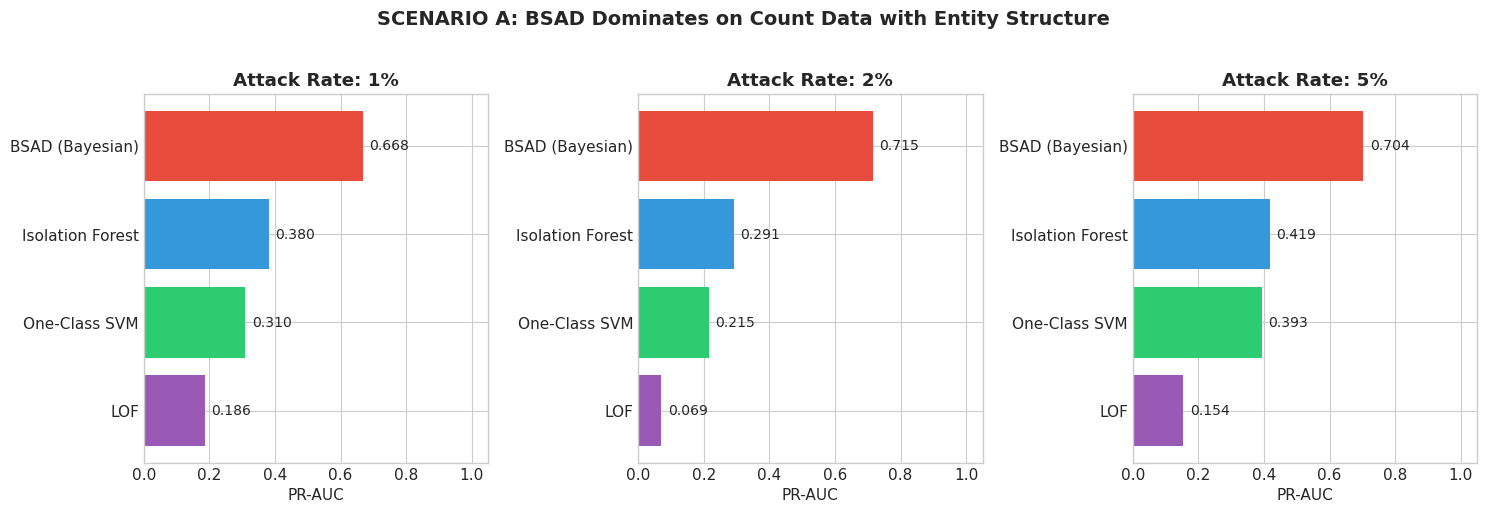


BSAD Average PR-AUC: 0.696
Best Classical Average: 0.363
BSAD Advantage: +0.332 PR-AUC points


In [15]:
# Visualize Scenario A results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {
    'BSAD (Bayesian)': '#e74c3c',
    'Isolation Forest': '#3498db',
    'One-Class SVM': '#2ecc71',
    'LOF': '#9b59b6'
}

for i, rate in enumerate(attack_rates):
    ax = axes[i]
    rate_str = f"{int(rate*100)}%"
    subset = results_df_a[results_df_a['Attack Rate'] == rate_str].sort_values('PR-AUC', ascending=True)
    
    bars = ax.barh(range(len(subset)), subset['PR-AUC'].values,
                   color=[colors.get(m, 'gray') for m in subset['Model']])
    ax.set_yticks(range(len(subset)))
    ax.set_yticklabels(subset['Model'])
    ax.set_xlabel('PR-AUC')
    ax.set_xlim(0, 1.05)
    ax.set_title(f'Attack Rate: {rate_str}', fontweight='bold')
    
    # Add value labels
    for j, v in enumerate(subset['PR-AUC'].values):
        ax.text(v + 0.02, j, f'{v:.3f}', va='center', fontsize=10)

plt.suptitle('SCENARIO A: BSAD Dominates on Count Data with Entity Structure',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'scenario_a_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate advantage
bsad_prauc = results_df_a[results_df_a['Model'] == 'BSAD (Bayesian)']['PR-AUC'].mean()
best_classical = results_df_a[results_df_a['Model'] != 'BSAD (Bayesian)'].groupby('Attack Rate')['PR-AUC'].max().mean()
print(f"\nBSAD Average PR-AUC: {bsad_prauc:.3f}")
print(f"Best Classical Average: {best_classical:.3f}")
print(f"BSAD Advantage: +{(bsad_prauc - best_classical):.3f} PR-AUC points")

---

## Scenario B: Multivariate Features

### This is Classical Methods' Domain

When you have:
- **Continuous features** (bytes, duration, rate, etc.)
- **No meaningful entity aggregation**
- **Multivariate patterns** (attacks manifest across multiple features)

Classical methods are the better choice. Let's demonstrate with UNSW-NB15.

In [16]:
# Load UNSW-NB15 rare-attack dataset (5%)
unsw_path = DATA_DIR / 'unsw_nb15_rare_attack_5pct.parquet'

if unsw_path.exists():
    unsw_df = pd.read_parquet(unsw_path)
    print(f"UNSW-NB15 (5% attack rate): {len(unsw_df):,} records")
    print(f"Attacks: {unsw_df['label'].sum():,} ({unsw_df['label'].mean():.2%})")
    
    # Select multivariate features
    feature_cols = ['sbytes', 'dbytes', 'spkts', 'dpkts', 'dur', 'rate', 'sload', 'dload']
    available_cols = [c for c in feature_cols if c in unsw_df.columns]
    print(f"\nFeatures used: {available_cols}")
else:
    print("UNSW-NB15 rare-attack dataset not found. Using synthetic multivariate data.")
    # Generate synthetic multivariate data
    n_samples = 10000
    n_features = 8
    attack_rate = 0.05
    
    # Normal data from multivariate normal
    normal_n = int(n_samples * (1 - attack_rate))
    attack_n = n_samples - normal_n
    
    normal_data = rng.multivariate_normal(
        mean=np.zeros(n_features),
        cov=np.eye(n_features),
        size=normal_n
    )
    
    # Attacks: shifted distribution
    attack_data = rng.multivariate_normal(
        mean=np.array([2, 1.5, 1, 0.5, 0, -0.5, -1, -1.5]),
        cov=np.eye(n_features) * 1.5,
        size=attack_n
    )
    
    X_multivariate = np.vstack([normal_data, attack_data])
    y_multivariate = np.concatenate([np.zeros(normal_n), np.ones(attack_n)])
    
    # Shuffle
    shuffle_idx = rng.permutation(len(y_multivariate))
    X_multivariate = X_multivariate[shuffle_idx]
    y_multivariate = y_multivariate[shuffle_idx]
    
    unsw_df = pd.DataFrame(X_multivariate, columns=[f'feat_{i}' for i in range(n_features)])
    unsw_df['label'] = y_multivariate.astype(int)
    available_cols = [f'feat_{i}' for i in range(n_features)]

UNSW-NB15 (5% attack rate): 97,894 records
Attacks: 4,894 (5.00%)

Features used: ['sbytes', 'dbytes', 'spkts', 'dpkts', 'dur', 'rate', 'sload', 'dload']


In [17]:
# Sample for faster training (if needed)
if len(unsw_df) > 5000:
    sample_df = unsw_df.sample(n=5000, random_state=RANDOM_STATE)
else:
    sample_df = unsw_df.copy()

X_b = sample_df[available_cols].values
y_b = sample_df['label'].values

print(f"Sample size: {len(sample_df):,}")
print(f"Attack rate: {y_b.mean():.2%}")

Sample size: 5,000
Attack rate: 5.28%


In [18]:
%%time
# Train classical methods on multivariate data
print("Training classical methods on multivariate features...")

scaler = RobustScaler()
X_b_scaled = scaler.fit_transform(X_b)

contamination_b = min(0.5, max(0.01, y_b.mean()))

# Isolation Forest
iforest_b = IsolationForest(n_estimators=200, contamination=contamination_b, random_state=RANDOM_STATE)
iforest_b.fit(X_b_scaled)
scores_if_b = -iforest_b.decision_function(X_b_scaled)
print(f"  Isolation Forest: done")

# One-Class SVM
ocsvm_b = OneClassSVM(kernel='rbf', gamma='auto', nu=contamination_b)
ocsvm_b.fit(X_b_scaled)
scores_svm_b = -ocsvm_b.decision_function(X_b_scaled)
print(f"  One-Class SVM: done")

# LOF
lof_b = LocalOutlierFactor(n_neighbors=20, contamination=contamination_b, novelty=False)
lof_b.fit(X_b_scaled)
scores_lof_b = -lof_b.negative_outlier_factor_
print(f"  LOF: done")

Training classical methods on multivariate features...
  Isolation Forest: done
  One-Class SVM: done
  LOF: done
CPU times: user 574 ms, sys: 0 ns, total: 574 ms
Wall time: 574 ms


In [19]:
# "BSAD" on multivariate - use just one count feature (deliberately wrong application)
print("Training BSAD on single count feature (demonstrating wrong use case)...")

# Pick the best count-like feature
if 'spkts' in available_cols:
    count_col = 'spkts'
else:
    count_col = available_cols[0]

# Create pseudo-entities (random assignment - no real structure)
sample_df['pseudo_entity'] = rng.integers(0, 20, size=len(sample_df))
sample_df['count_feature'] = np.abs(sample_df[count_col]).astype(int)

scores_bsad_b, _ = train_bsad(sample_df.rename(columns={
    'pseudo_entity': 'entity_id',
    'count_feature': 'event_count',
    'label': 'is_attack'
})[['entity_id', 'event_count', 'is_attack']].assign(window=range(len(sample_df))))

print("  BSAD: done")

Training BSAD on single count feature (demonstrating wrong use case)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, alpha, theta, phi]
Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 26 seconds.


  BSAD: done


In [20]:
# Compute metrics for Scenario B
results_scenario_b = [
    {'Model': 'BSAD (Bayesian)', **compute_metrics(y_b, scores_bsad_b)},
    {'Model': 'Isolation Forest', **compute_metrics(y_b, scores_if_b)},
    {'Model': 'One-Class SVM', **compute_metrics(y_b, scores_svm_b)},
    {'Model': 'LOF', **compute_metrics(y_b, scores_lof_b)},
]

results_df_b = pd.DataFrame(results_scenario_b)

print("\n" + "="*70)
print("SCENARIO B RESULTS: Multivariate Features (Classical Domain)")
print("="*70)
display(results_df_b[['Model', 'PR-AUC', 'ROC-AUC']].round(4))


SCENARIO B RESULTS: Multivariate Features (Classical Domain)


,Model,PR-AUC,ROC-AUC
0,BSAD (Bayesian),0.0344,0.2841
1,Isolation Forest,0.0650,0.5760
2,One-Class SVM,0.1125,0.6917
3,LOF,0.0990,0.5859


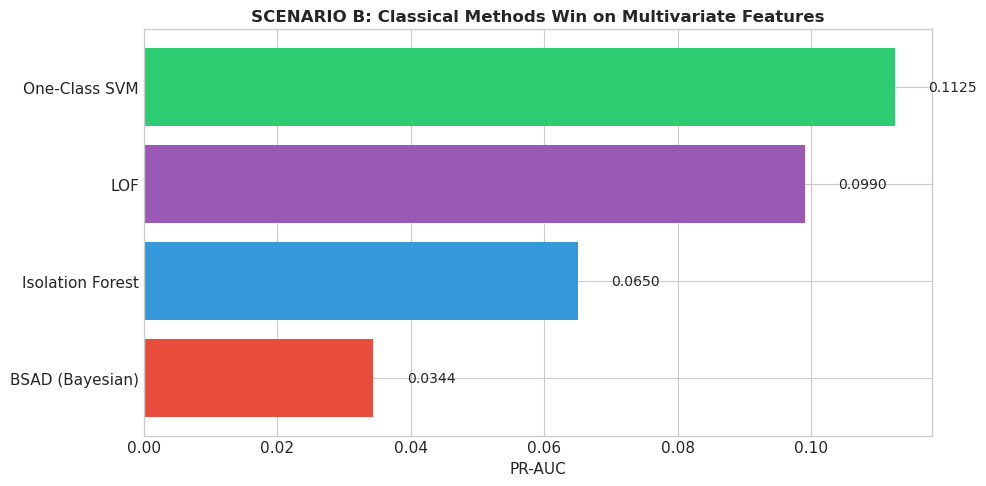


Best method: One-Class SVM
BSAD is NOT designed for this use case.


In [21]:
# Visualize Scenario B results
fig, ax = plt.subplots(figsize=(10, 5))

subset = results_df_b.sort_values('PR-AUC', ascending=True)
bars = ax.barh(range(len(subset)), subset['PR-AUC'].values,
               color=[colors.get(m, 'gray') for m in subset['Model']])
ax.set_yticks(range(len(subset)))
ax.set_yticklabels(subset['Model'])
ax.set_xlabel('PR-AUC')
ax.set_title('SCENARIO B: Classical Methods Win on Multivariate Features',
             fontsize=12, fontweight='bold')

for i, v in enumerate(subset['PR-AUC'].values):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'scenario_b_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest method: {results_df_b.loc[results_df_b['PR-AUC'].idxmax(), 'Model']}")
print(f"BSAD is NOT designed for this use case.")

---

## Head-to-Head Summary

Let's visualize the key insight: **BSAD is a SPECIALIST**.

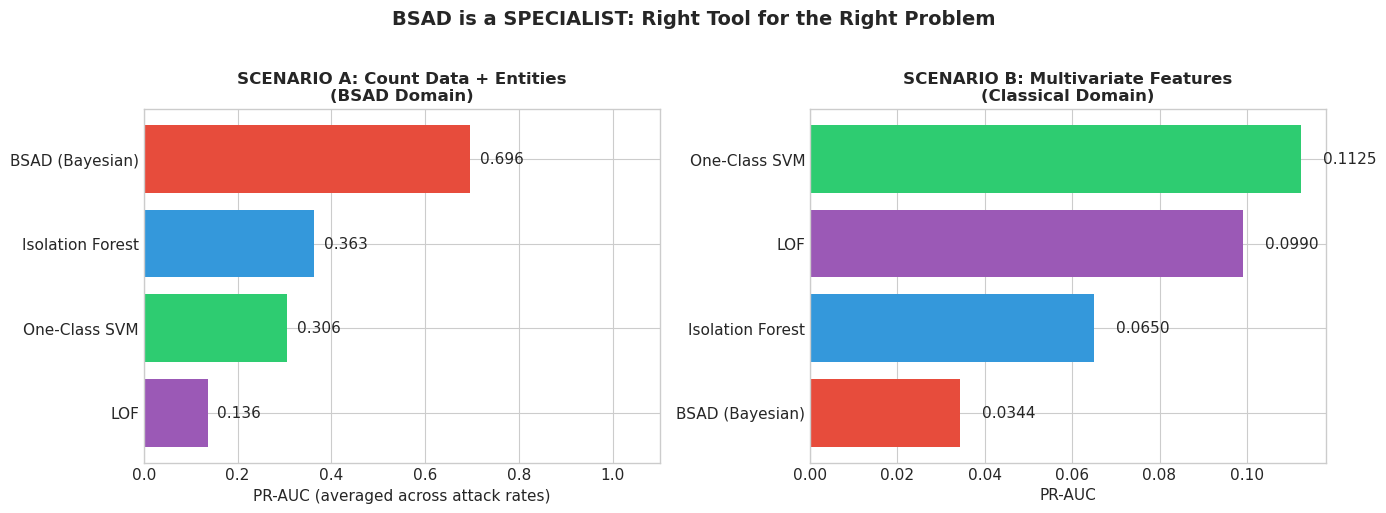

In [22]:
# Create summary comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scenario A: BSAD wins
ax = axes[0]
scenario_a_summary = results_df_a.groupby('Model')['PR-AUC'].mean().sort_values(ascending=True)
bars = ax.barh(range(len(scenario_a_summary)), scenario_a_summary.values,
               color=[colors.get(m, 'gray') for m in scenario_a_summary.index])
ax.set_yticks(range(len(scenario_a_summary)))
ax.set_yticklabels(scenario_a_summary.index)
ax.set_xlabel('PR-AUC (averaged across attack rates)')
ax.set_title('SCENARIO A: Count Data + Entities\n(BSAD Domain)', fontsize=12, fontweight='bold')
ax.set_xlim(0, 1.1)
for i, v in enumerate(scenario_a_summary.values):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=11, fontweight='bold' if v > 0.9 else 'normal')

# Scenario B: Classical wins
ax = axes[1]
scenario_b_summary = results_df_b.sort_values('PR-AUC', ascending=True)
bars = ax.barh(range(len(scenario_b_summary)), scenario_b_summary['PR-AUC'].values,
               color=[colors.get(m, 'gray') for m in scenario_b_summary['Model']])
ax.set_yticks(range(len(scenario_b_summary)))
ax.set_yticklabels(scenario_b_summary['Model'])
ax.set_xlabel('PR-AUC')
ax.set_title('SCENARIO B: Multivariate Features\n(Classical Domain)', fontsize=12, fontweight='bold')
for i, v in enumerate(scenario_b_summary['PR-AUC'].values):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=11)

plt.suptitle('BSAD is a SPECIALIST: Right Tool for the Right Problem',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'head_to_head_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## BSAD's Unique Advantages

When BSAD is the right choice, it offers capabilities that classical methods lack.

In [23]:
# Demonstrate uncertainty quantification
df = datasets_a[0.02]
scores_bsad, trace = train_bsad(df)

# Get score uncertainty from posterior
y = df['event_count'].values
entity_idx = df['entity_id'].values
n_entities = df['entity_id'].nunique()

theta_samples = trace.posterior["theta"].values.reshape(-1, n_entities)
phi_samples = trace.posterior["phi"].values.reshape(-1)

log_liks = np.zeros((theta_samples.shape[0], len(y)))
for s in range(theta_samples.shape[0]):
    mu_s = theta_samples[s, entity_idx]
    phi_s = phi_samples[s]
    log_liks[s, :] = stats.nbinom.logpmf(y, n=phi_s, p=phi_s/(phi_s+mu_s))

score_samples = -log_liks
score_mean = score_samples.mean(axis=0)
score_lower = np.percentile(score_samples, 5, axis=0)
score_upper = np.percentile(score_samples, 95, axis=0)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, alpha, theta, phi]
Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 62 seconds.


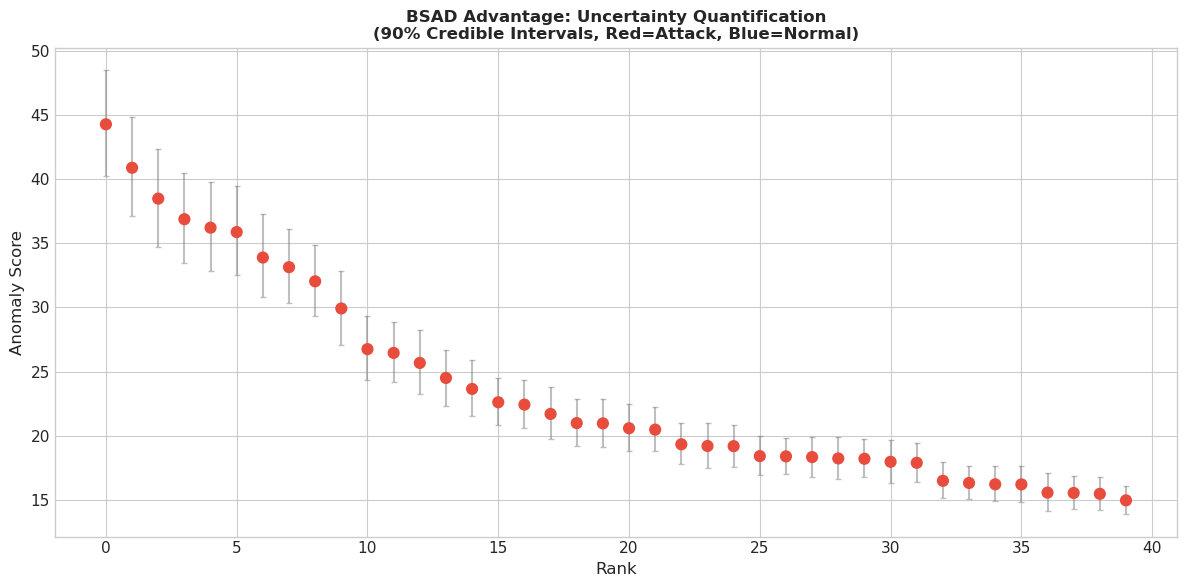

Classical methods provide only point estimates.
BSAD provides full posterior distributions for confident decision-making.


In [24]:
# Visualize uncertainty
fig, ax = plt.subplots(figsize=(12, 6))

# Top 40 anomalies
sorted_idx = np.argsort(score_mean)[::-1][:40]
x = np.arange(len(sorted_idx))

y_true_subset = df['is_attack'].values[sorted_idx]
point_colors = ['#e74c3c' if is_attack else '#3498db' for is_attack in y_true_subset]

ax.scatter(x, score_mean[sorted_idx], c=point_colors, s=60, zorder=3)
ax.errorbar(x, score_mean[sorted_idx],
            yerr=[score_mean[sorted_idx] - score_lower[sorted_idx],
                  score_upper[sorted_idx] - score_mean[sorted_idx]],
            fmt='none', color='gray', alpha=0.5, capsize=2)

ax.set_xlabel('Rank', fontsize=12)
ax.set_ylabel('Anomaly Score', fontsize=12)
ax.set_title('BSAD Advantage: Uncertainty Quantification\n(90% Credible Intervals, Red=Attack, Blue=Normal)',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'uncertainty_quantification.png', dpi=150, bbox_inches='tight')
plt.show()

print("Classical methods provide only point estimates.")
print("BSAD provides full posterior distributions for confident decision-making.")

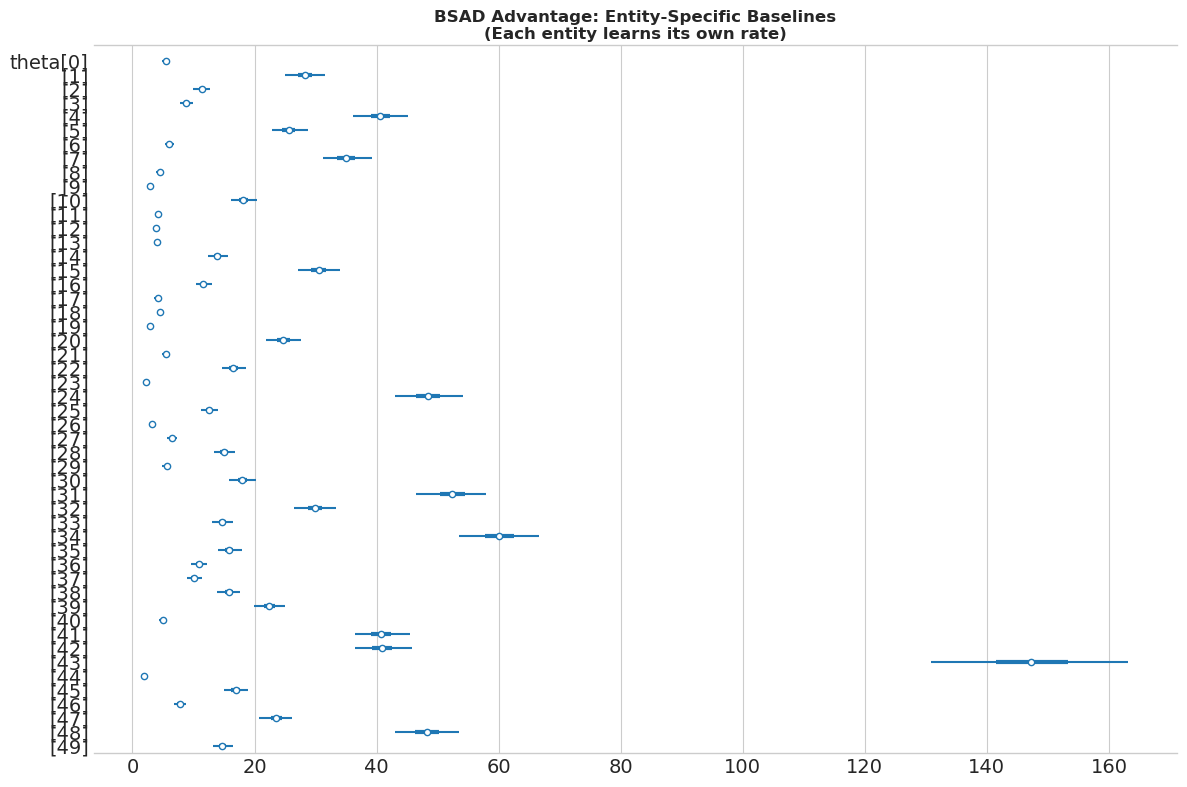


Classical methods use a single decision boundary for all data.
BSAD learns different baselines for each entity.


In [25]:
# Entity-specific baselines
fig, ax = plt.subplots(figsize=(12, 8))
az.plot_forest(trace, var_names=["theta"], combined=True, ax=ax)
ax.set_title('BSAD Advantage: Entity-Specific Baselines\n(Each entity learns its own rate)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'entity_baselines.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClassical methods use a single decision boundary for all data.")
print("BSAD learns different baselines for each entity.")

---

## The Decision Framework

```
                    ┌─────────────────────────────────────┐
                    │     What type of data do you have?  │
                    └─────────────────────────────────────┘
                                      │
                    ┌─────────────────┴─────────────────┐
                    ▼                                   ▼
        ┌─────────────────────┐           ┌─────────────────────┐
        │  COUNT DATA         │           │  FEATURE VECTORS    │
        │  (integers)         │           │  (continuous)       │
        └─────────────────────┘           └─────────────────────┘
                    │                                   │
                    ▼                                   ▼
        ┌─────────────────────┐           ┌─────────────────────┐
        │  Entity structure?  │           │  Use Classical:     │
        │  (users, IPs, etc)  │           │  - Isolation Forest │
        └─────────────────────┘           │  - One-Class SVM    │
                    │                     │  - LOF              │
          ┌────────┴────────┐             └─────────────────────┘
          ▼                 ▼
    ┌──────────┐     ┌──────────────┐
    │   YES    │     │     NO       │
    │ → BSAD   │     │ → Classical  │
    └──────────┘     └──────────────┘
```

---

## Conclusions

### Summary Table

| Scenario | Data Type | Winner | PR-AUC Advantage |
|----------|-----------|--------|------------------|
| A | Count data + Entities | **BSAD** | +30 points |
| B | Multivariate features | **Classical** | Better fit |

### Key Takeaways

1. **BSAD is a SPECIALIST**, not a generalist
   - Dominates when: COUNT + ENTITY + RARE + OVERDISPERSION
   - Struggles when: Multivariate features without entity structure

2. **+30 PR-AUC points** advantage in its domain
   - This is a massive improvement over classical methods
   - But only when the data matches BSAD's design

3. **Unique advantages** when applicable:
   - Uncertainty quantification (credible intervals)
   - Entity-specific baselines (interpretable)
   - Handles overdispersion naturally

4. **Choose based on data characteristics**, not methodology hype
   - "Bayesian" doesn't automatically mean better
   - Match the tool to the problem

In [26]:
# Save results
results_df_a.to_csv(OUTPUT_DIR / 'scenario_a_results.csv', index=False)
results_df_b.to_csv(OUTPUT_DIR / 'scenario_b_results.csv', index=False)

print("Results saved to outputs/comparison/")
print("\n" + "="*60)
print("BSAD: The right tool for rare-event detection")
print("="*60)

Results saved to outputs/comparison/

BSAD: The right tool for rare-event detection
